# Bilanci regioni 2018 - 2023
dati Banca d'Italia

In [7]:
import pandas as pd

# Carichiamo il file CSV
file_path = "D:/Bankit_ratios_20182023.csv"


In [8]:
with open(file_path, "r", encoding="utf-8") as f:
    lines = f.readlines()
data_lines = [line.strip() for line in lines if line.strip() and not line.startswith("##")]
parsed_rows = []
for line in data_lines[1:]:  # saltiamo intestazione
    parts = line.split()
    regione = parts[0]
    # identifichiamo l'inizio dei numeri (percentuali), che sono da dividere dal nome della voce
    for i, part in enumerate(parts):
        try:
            float(part.replace(",", "."))
            split_index = i
            break
        except ValueError:
            continue
    voce = " ".join(parts[1:split_index])
    valori = [float(p.replace(",", ".")) for p in parts[split_index:]]
    parsed_rows.append([regione, voce] + valori)

columns = ["Regione", "Voce", "2018", "2019", "2020", "2021", "2022", "2023"]
df = pd.DataFrame(parsed_rows, columns=columns)
df.shape, df.sample(20).to_clipboard()

((339, 8), None)

In [9]:
df[df['Regione']=='MOL'][['Voce','2023']] #.to_clipboard()

,Voce,2023
102,Debiti bancari / Debiti finanziari,73.3
103,Debiti finanziari / Fatturato,17.2
104,Indice di gestione incassi e pagamenti,12.2
105,Leverage,35.7
106,Leverage corretto per la liquidità,20.2
107,Liquidità corrente,141.5
108,Liquidità immediata,114.9
109,Liquidità/attivo,10.5
110,Margine operativo lordo/attivo,11.3
111,Margine operativo lordo/valore aggiunto,45.2


In [10]:
df.to_csv('D:/Bilanci_20182023.tsv', sep='|', index=False)

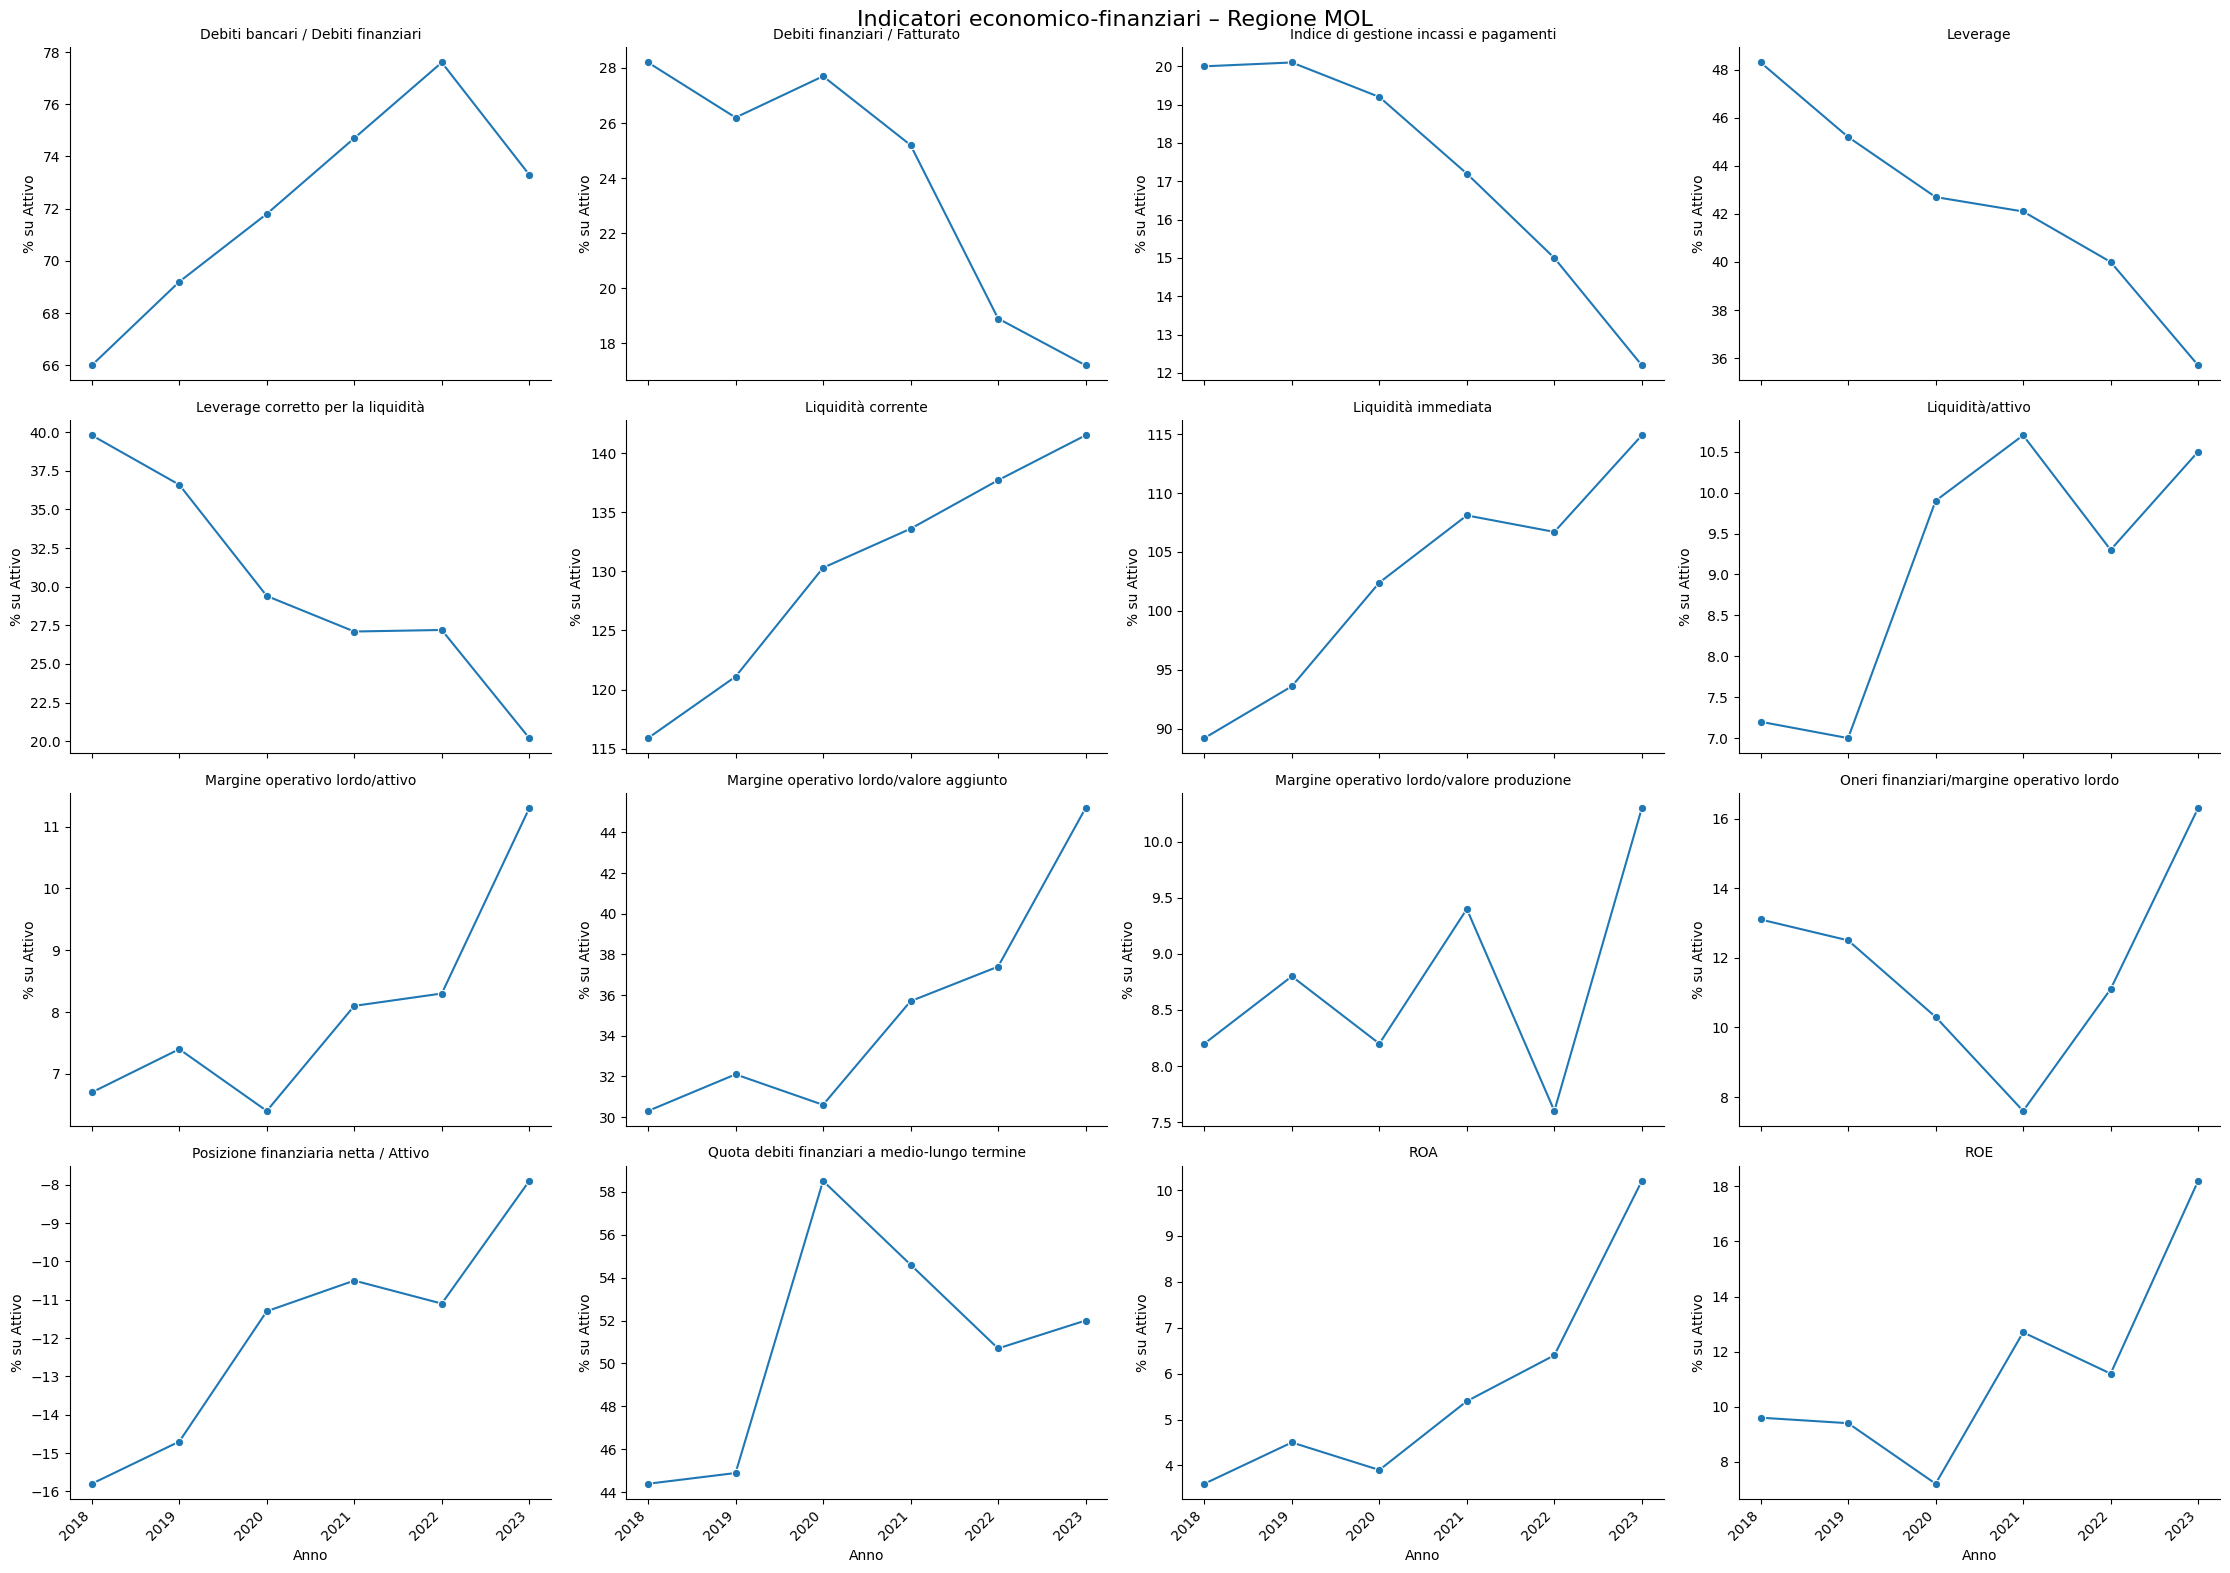

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtro regione
df_puglia = df[df["Regione"] == "MOL"]
regione = df_puglia["Regione"].iloc[0]

# Long format
df_long = df_puglia.melt(
    id_vars=["Regione", "Voce"],
    value_vars=["2018", "2019", "2020", "2021", "2022", "2023"],
    var_name="Anno",
    value_name="Valore"
)

# Ordine delle voci
voci_ordinate = sorted(df_long["Voce"].unique())
df_long["Voce"] = pd.Categorical(df_long["Voce"], categories=voci_ordinate, ordered=True)

# FacetGrid
g = sns.FacetGrid(df_long, col="Voce", col_wrap=4, height=4, aspect=1.4, sharey=False)
g.map_dataframe(sns.lineplot, x="Anno", y="Valore", marker="o")

# Etichette e rotazione
for ax in g.axes.flat:
    ax.set_xlabel("Anno")
    ax.set_ylabel("% su Attivo")
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment("right")

g.set_titles(col_template="{col_name}")

# Allontanamento del titolo
plt.subplots_adjust(top=0.88)  # ← cambia qui per aumentare la distanza
plt.suptitle(f"Indicatori economico-finanziari – Regione {regione}", fontsize=16)

plt.tight_layout()
plt.show()


In [6]:
df_long

,Regione,Voce,Anno,Valore
0,MOL,Debiti bancari / Debiti finanziari,2018,66.0
1,MOL,Debiti finanziari / Fatturato,2018,28.2
2,MOL,Indice di gestione incassi e pagamenti,2018,20.0
3,MOL,Leverage,2018,48.3
4,MOL,Leverage corretto per la liquidità,2018,39.8
...,...,...,...,...
91,MOL,Oneri finanziari/margine operativo lordo,2023,16.3
92,MOL,Posizione finanziaria netta / Attivo,2023,-7.9
93,MOL,Quota debiti finanziari a medio-lungo termine,2023,52.0
94,MOL,ROA,2023,10.2


In [7]:
import pandas as pd
from scipy.stats import zscore
import seaborn as sns
import matplotlib.pyplot as plt

# Ristrutturiamo in formato long
df_long = df.melt(id_vars=["Regione", "Voce"], var_name="Anno", value_name="Valore")

## ricostruzione bilancio

In [8]:
# Assumiamo che `df` sia già correttamente strutturato in memoria con colonne:
# ["Regione", "Voce", "2018", "2019", "2020", "2021", "2022", "2023"]

# Convertiamo le colonne anno in float (se non già fatto)
anni = ["2018", "2019", "2020", "2021", "2022", "2023"]
for year in anni:
    df[year] = pd.to_numeric(df[year], errors="coerce")

# Pivot per ogni anno
pivot_anni = {
    anno: df[["Regione", "Voce", anno]].pivot(index="Regione", columns="Voce", values=anno)
    for anno in anni
}

# Funzione per ricostruire SP + CE
def ricostruisci_bilancio_e_ce(indici: pd.Series) -> dict:
    ATTIVO = 100
    try:
        mol_attivo = indici['Margine operativo lordo/attivo']
        mol_va = indici['Margine operativo lordo/valore aggiunto']
        mol_vp = indici['Margine operativo lordo/valore produzione']
        roa = indici['ROA']
        roe = indici['ROE']
        oneri_mol = indici['Oneri finanziari/margine operativo lordo']
        leverage = indici['Leverage']
        pfn_attivo = indici['Posizione finanziaria netta / Attivo']
        liquid_attivo = indici['Liquidità/attivo']
    except KeyError:
        return None

    mol = mol_attivo / 100 * ATTIVO
    valore_aggiunto = mol / (mol_va / 100)
    valore_produzione = mol / (mol_vp / 100)
    oneri_finanziari = mol * (oneri_mol / 100)
    utile_ante_oneri = roa / 100 * ATTIVO
    utile_netto = utile_ante_oneri - oneri_finanziari
    pn = ATTIVO / (1 + leverage)
    passivo = ATTIVO - pn
    liquidita = liquid_attivo / 100 * ATTIVO
    pfn = pfn_attivo / 100 * ATTIVO
    df = pfn + liquidita
    dnf = passivo - df

    return {
        "CE": {
            "Valore produzione": valore_produzione,
            "Valore aggiunto": valore_aggiunto,
            "MOL": mol,
            "Oneri finanziari": oneri_finanziari,
            "Utile ante oneri finanziari": utile_ante_oneri,
            "Utile netto": utile_netto,
        },
        "SP": {
            "Attivo": ATTIVO,
            "Liquidità": liquidita,
            "Debiti finanziari": df,
            "Debiti non finanziari": dnf,
            "Patrimonio netto": pn,
            "Passivo": passivo,
            "PFN (DF - Liquidità)": df - liquidita
        }
    }

# Applichiamo a tutti gli anni e regioni
ce_records = []
sp_records = []

for anno, df_pivot in pivot_anni.items():
    outputs = df_pivot.apply(ricostruisci_bilancio_e_ce, axis=1)
    for regione, result in outputs.items():
        if result:
            ce_row = result["CE"]
            ce_row["Regione"] = regione
            ce_row["Anno"] = anno
            ce_records.append(ce_row)
            sp_row = result["SP"]
            sp_row["Regione"] = regione
            sp_row["Anno"] = anno
            sp_records.append(sp_row)

# Salviamo i risultati
df_ce_completo = pd.DataFrame(ce_records)
df_sp_completo = pd.DataFrame(sp_records)


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtriamo i dati per la regione Puglia
ce_pug = df_ce_completo[df_ce_completo["Regione"] == "PUG"].sort_values("Anno")
sp_pug = df_sp_completo[df_sp_completo["Regione"] == "PUG"].sort_values("Anno")

# Uniamo CE e SP in un unico DataFrame lungo per plotting
ce_long = ce_pug.melt(id_vars=["Regione", "Anno"], var_name="Voce", value_name="Valore")
sp_long = sp_pug.melt(id_vars=["Regione", "Anno"], var_name="Voce", value_name="Valore")

df_plot = pd.concat([ce_long, sp_long])

# Ordiniamo le voci per migliore leggibilità
voci_ordinate = sorted(df_plot["Voce"].unique(), key=lambda x: (("Valore" not in x) and ("Utile" not in x), x))
df_plot["Voce"] = pd.Categorical(df_plot["Voce"], categories=voci_ordinate, ordered=True)

'''# Grafico FacetGrid
g = sns.FacetGrid(df_plot, col="Voce", col_wrap=5, height=2.5, aspect=1.4,sharey=False)
g.map_dataframe(sns.lineplot, x="Anno", y="Valore", marker="o")
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Anno", "% su Attivo")
g.tight_layout()
plt.show()'''


'# Grafico FacetGrid\ng = sns.FacetGrid(df_plot, col="Voce", col_wrap=5, height=2.5, aspect=1.4,sharey=False)\ng.map_dataframe(sns.lineplot, x="Anno", y="Valore", marker="o")\ng.set_titles(col_template="{col_name}")\ng.set_axis_labels("Anno", "% su Attivo")\ng.tight_layout()\nplt.show()'

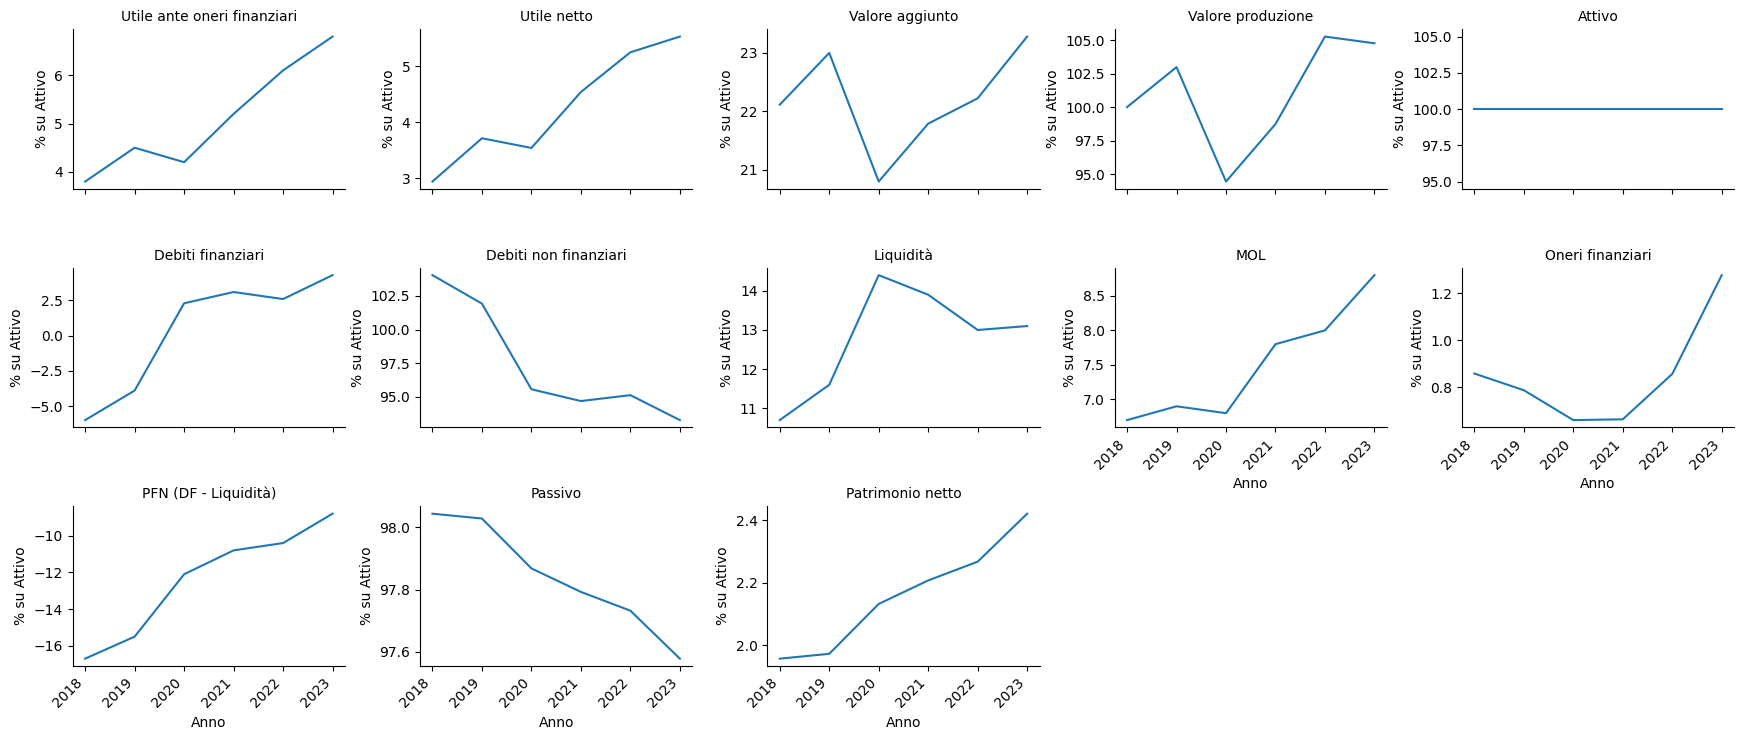

In [13]:
# Ricreiamo il FacetGrid con label esplicite su ogni facet
g = sns.FacetGrid(df_plot, col="Voce", col_wrap=5, height=2.5, aspect=1.4, sharey=False)
g.map_dataframe(sns.lineplot, x="Anno", y="Valore", )

# Impostiamo titolo e label asse per ciascun asse individualmente
for ax in g.axes.flat:
    ax.set_xlabel("Anno")
    ax.set_ylabel("% su Attivo")
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment("right")

g.set_titles(col_template="{col_name}")
g.tight_layout()
plt.show()


## standardizzazione (Z-score) e radar

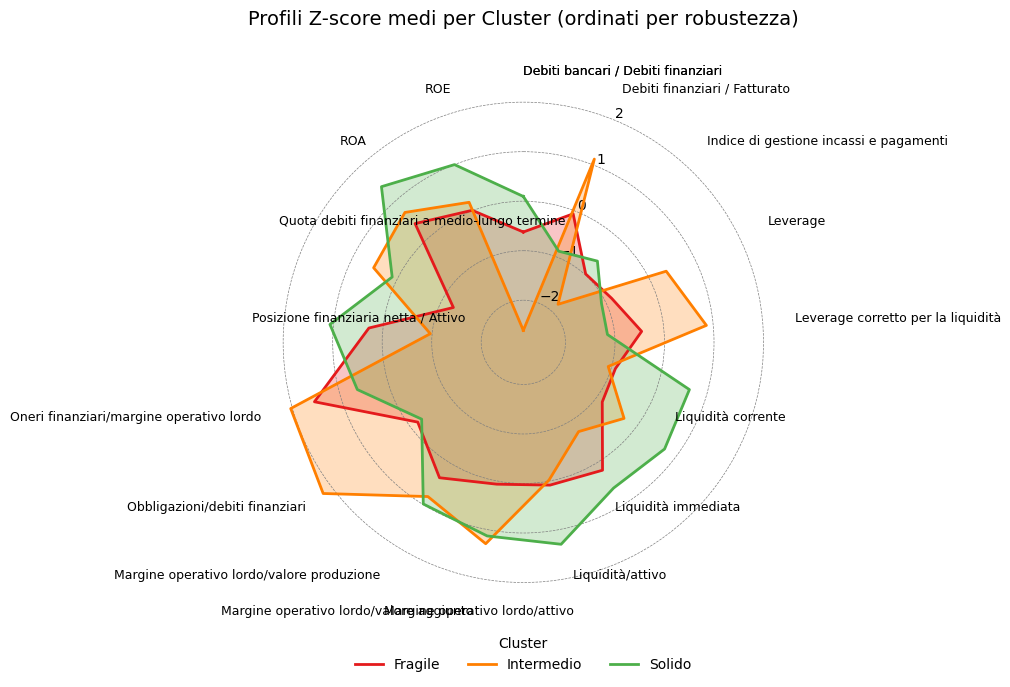

In [22]:
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Calcolo dello z-score per ogni ratio
df_long["Zscore"] = df_long.groupby("Voce")["Valore"].transform(zscore)

# Selezione dati per il 2023
df_2023 = df_long[df_long["Anno"] == "2023"].pivot(index="Regione", columns="Voce", values="Zscore")

# Pulizia NaN se presenti
df_2023_clean = df_2023.dropna()

# Standardizzazione
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_2023_clean)

# PCA per riduzione dimensionale
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Clustering KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_pca)

# Aggiunta cluster ai dati originali
df_clustered = df_2023_clean.copy()
df_clustered["Cluster"] = labels

# Calcolo medie per cluster
cluster_means = df_clustered.groupby("Cluster").mean(numeric_only=True)

import numpy as np
import matplotlib.pyplot as plt

# Ordina i cluster in base alla somma dei valori medi (proxy per "solidità")
cluster_scores = cluster_means.sum(axis=1)
sorted_clusters = cluster_scores.sort_values().index.tolist()

# Mappatura dei cluster
cluster_means_sorted = cluster_means.loc[sorted_clusters]
cluster_labels = {sorted_clusters[0]: "Fragile", sorted_clusters[1]: "Intermedio", sorted_clusters[2]: "Solido"}
color_map = {
    "Fragile": "#e41a1c",     # Rosso
    "Solido": "#4daf4a",      # Verde
    "Intermedio": "#ff7f00"   # Arancione
}

# Radar plot
labels = cluster_means_sorted.columns.tolist()
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # chiusura cerchio

fig, ax = plt.subplots(figsize=(11, 7), subplot_kw=dict(polar=True))

for cluster_id in sorted_clusters:
    row = cluster_means_sorted.loc[cluster_id]
    values = row.tolist() + [row.tolist()[0]]
    label = cluster_labels[cluster_id]
    color = color_map[label]
    ax.plot(angles, values, label=label, linewidth=2, color=color)
    ax.fill(angles, values, alpha=0.25, color=color)

# Impostazioni estetiche
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks([])

for angle, label in zip(angles, labels + [labels[0]]):
    ha = "left" if np.cos(angle) >= 0 else "right"
    ax.text(
        angle,
        ax.get_rmax() * 1.08,
        label,
        size=9,
        horizontalalignment=ha,
        verticalalignment="center",
        rotation=0
    )

ax.yaxis.grid(True, color="gray", linestyle="--", linewidth=0.5)
ax.spines["polar"].set_visible(False)

plt.title("Profili Z-score medi per Cluster (ordinati per robustezza)", size=14, pad=40)
plt.legend(title="Cluster", loc="lower center", bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False)
plt.tight_layout()
plt.show()


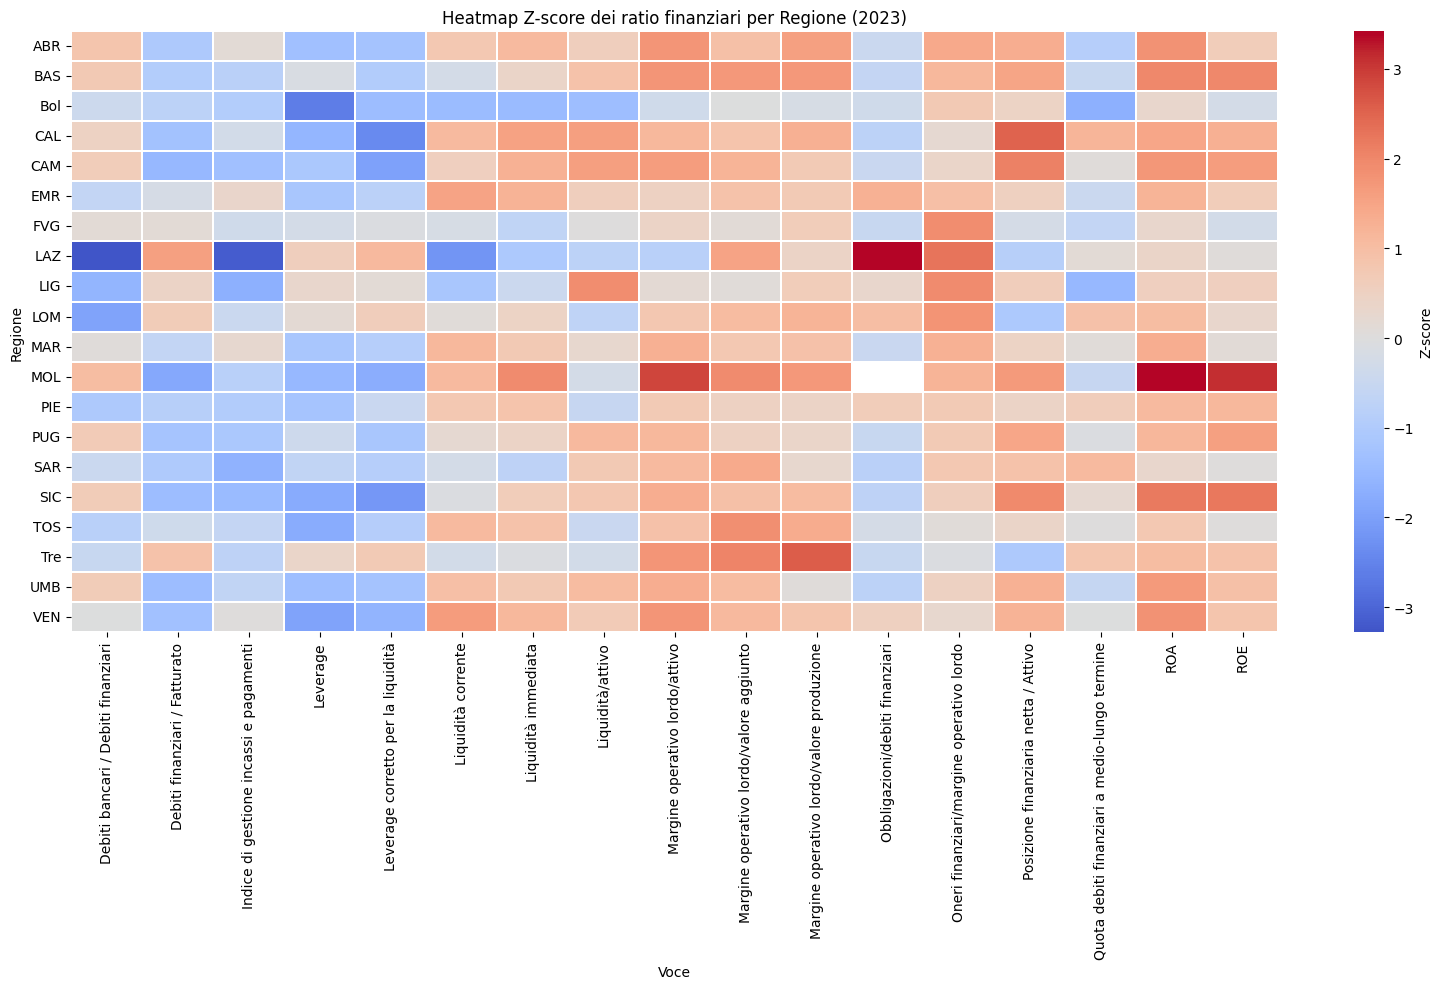

In [11]:
# Calcolo dello z-score per ogni ratio
df_long["Zscore"] = df_long.groupby("Voce")["Valore"].transform(zscore)

# Heatmap per il 2023
df_2023 = df_long[df_long["Anno"] == "2023"].pivot(index="Regione", columns="Voce", values="Zscore")

plt.figure(figsize=(16, 10))
sns.heatmap(df_2023, cmap="coolwarm", center=0, annot=False, linewidths=0.3, cbar_kws={"label": "Z-score"})
plt.title("Heatmap Z-score dei ratio finanziari per Regione (2023)")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## Clusterizzazione delle regioni (KMeans o dendrogramma)

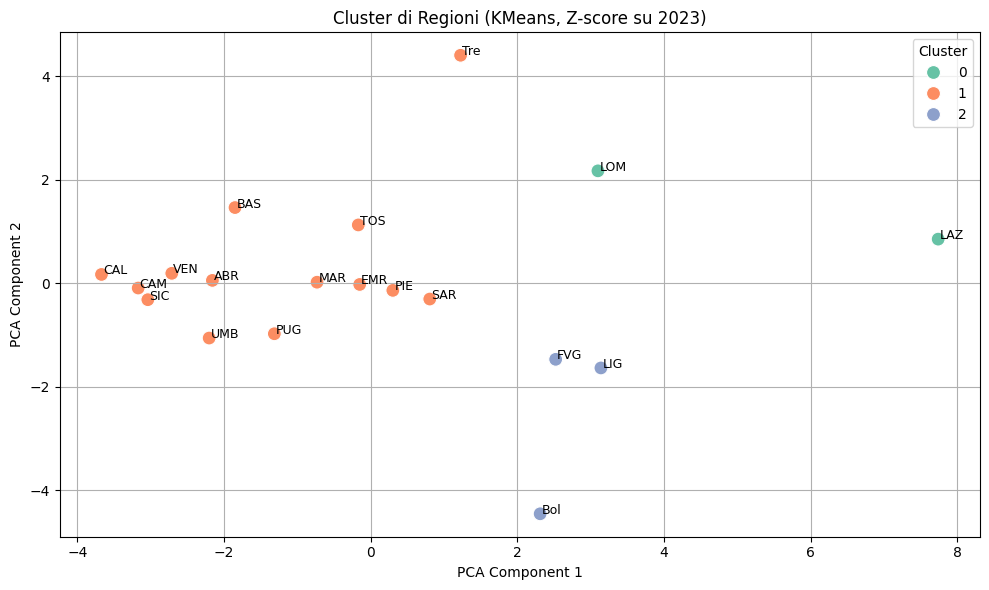

In [12]:
# Rilanciamo PCA e clustering con definizione esplicita degli oggetti persi
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Scala i dati
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_2023_clean)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Clustering KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_pca)

# Prepara dataframe con risultati
df_clusters = pd.DataFrame({
    "Regione": df_2023_clean.index,
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1],
    "Cluster": labels
})

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_clusters, x="PC1", y="PC2", hue="Cluster", palette="Set2", s=100)
for i in range(df_clusters.shape[0]):
    plt.text(df_clusters["PC1"][i] + 0.02, df_clusters["PC2"][i], df_clusters["Regione"][i], fontsize=9)
plt.title("Cluster di Regioni (KMeans, Z-score su 2023)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()


### Radar

In [13]:
# Aggiungiamo i cluster all'originale df_2023_clean per fare le medie dei ratio per cluster
df_clustered = df_2023_clean.copy()

df_clustered["Cluster"] = labels

# Calcoliamo la media dei ratio per ogni cluster
cluster_means = df_clustered.groupby("Cluster").mean(numeric_only=True)

# Visualizziamo come tabella
import pandas as pd
cluster_means


Voce,Debiti bancari / Debiti finanziari,Debiti finanziari / Fatturato,Indice di gestione incassi e pagamenti,Leverage,Leverage corretto per la liquidità,Liquidità corrente,Liquidità immediata,Liquidità/attivo,Margine operativo lordo/attivo,Margine operativo lordo/valore aggiunto,Margine operativo lordo/valore produzione,Obbligazioni/debiti finanziari,Oneri finanziari/margine operativo lordo,Posizione finanziaria netta / Attivo,Quota debiti finanziari a medio-lungo termine,ROA,ROE
Cluster,,,,,,,,,,,,,,,,,
0,-2.609514,1.118446,-1.811085,0.372717,0.862160,-1.068977,-0.301723,-0.730521,-0.022857,1.286756,0.812454,2.215099,2.034251,-0.963284,0.527223,0.699347,0.182372
1,0.095707,-0.876685,-0.630539,-1.087626,-1.144607,0.636247,0.723705,0.610727,1.298320,1.127397,0.988362,-0.276935,0.635305,1.072152,0.108728,1.403199,0.998900
2,-0.622477,-0.067051,-0.981920,-0.857532,-0.451346,-0.917150,-0.853570,0.186917,0.082636,0.063604,0.365785,-0.177620,1.535683,0.281691,-1.271999,0.394810,0.009170
